In [4]:
import os
import math
import numpy as np
import pandas as pd
import ccxt
import talib
from datetime import datetime
import tensorflow as tf
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from script.fetch_history_data import binance_fetch_history_price, binance_single_fetch_history_price
from script.preprocess import *
from sklearn.preprocessing import StandardScaler
from script.transformer_timestep import *
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pickle
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

Tensorflow version: 2.6.5


In [5]:
batch_size = 32
seq_len = 128
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256
valid_percent = 20
test_percent = 10

target_column='Close_MA_ptc_10'
pearson_corr_cutoff = 0.2

# with open('multi_factor_v2.0.1.pickle', 'rb') as input_pickle:
#     multi_factor_dic = pickle.load(input_pickle)

# zscore_col = multi_factor_dic['zscore'][0]
# zscore_std = multi_factor_dic['zscore'][1]
# zscore_mean = multi_factor_dic['zscore'][2]
# input_col = multi_factor_dic['input_col']

In [6]:
def calculate_z_score_input_format(df_cal):
    for col in zscore_col:
        df_cal[col] = (df_cal[col] - zscore_mean) / zscore_std
    df_cal['Volume_zscore'] = (df_cal['Volume'] - vol_zscore_mean) / vol_zscore_std
    return df_cal[input_col], df_cal

In [8]:
df = binance_fetch_history_price(coin='BTC/USDT', timeframe='1h', start_date='2019-09-10')
timeframes = [10,20,40,60,80,100,120,140,160,180,200]
df_cal = calculate_technical_indicators(df, timeframes=timeframes)
df_train, df_val, df_test = preprocess_train_test_split(df_cal, valid_percent=valid_percent, test_percent=test_percent)
#df_cal.to_pickle('./data/multi_factor_v2.0.2.pickle')

#### Generate the Z-score std mean dictionary & Using pearson correlation to filter features 

In [5]:
df_cal = pd.read_pickle('./data/multi_factor_v2.0.2.pickle')
df_train, df_val, df_test = preprocess_train_test_split(df_cal, valid_percent=valid_percent, test_percent=test_percent)
df_cal_drop_col = df_train.copy()

# select MA columns to calculate Z-score
#del df_cal_drop_col['Timestamp']
ma_ptc_col = [col for col in df_cal_drop_col.columns if 'MA_ptc' in col and 'Volume' not in col and col != 'Timestamp']
ma_ptc_col += ['ZhangDieFu', 'ZhenFu']	
zscore_std = df_cal_drop_col[ma_ptc_col].values.reshape(-1).std()
zscore_mean = df_cal_drop_col[ma_ptc_col].values.reshape(-1).mean()


# select Volume to calculate Z-score    
vol_zscore_std = df_cal_drop_col['Volume'].values.reshape(-1).std()
vol_zscore_mean = df_cal_drop_col['Volume'].values.reshape(-1).mean()
df_cal_drop_col['Volume_zscore'] = (df_cal_drop_col['Volume'] - vol_zscore_mean) / vol_zscore_std


# # select Volume_ma_ptc_col to calculate Z-score    
# vol_ma_col = [col for col in df_cal_drop_col.columns if 'Volume_MA' in col and 'ptc' not in col and col != 'Timestamp']
# vol_ma_zscore_std = df_cal_drop_col[vol_ma_col].values.reshape(-1).std()
# vol_ma_zscore_mean = df_cal_drop_col[vol_ma_col].values.reshape(-1).mean()
# for col in vol_ma_col:
#     df_cal_drop_col[col] = (df_cal_drop_col[col] - vol_ma_zscore_mean) / vol_ma_zscore_std

# # select Volume_ma_ptc_col to calculate Z-score    
# vol_ma_ptc_col = [col for col in df_cal_drop_col.columns if 'Volume_MA_ptc_' in col and col != 'Timestamp']
# vol_ma_ptc_zscore_std = df_cal_drop_col[vol_ma_ptc_col].values.reshape(-1).std()
# vol_ma_ptc_zscore_mean = df_cal_drop_col[vol_ma_ptc_col].values.reshape(-1).mean()
# for col in vol_ma_ptc_col:
#     df_cal_drop_col[col] = (df_cal_drop_col[col] - vol_ma_ptc_zscore_mean) / vol_ma_ptc_zscore_std

# pearson corr filter
filterd_col = [col for col in df_cal_drop_col.columns[(df_cal_drop_col.corr()[target_column].abs() >= pearson_corr_cutoff)]]
#minmax_df = df_cal_drop_col[filterd_col]

# save z-score to dictionary
multi_factor_dic = {}
multi_factor_dic['zscore'] = [ma_ptc_col, zscore_std, zscore_mean]
multi_factor_dic['vol_zscore'] = ['Volume', vol_zscore_std, vol_zscore_mean]
#multi_factor_dic['vol_ma_ptc_zscore'] = [vol_ma_ptc_col, vol_ma_ptc_zscore_std, vol_ma_ptc_zscore_mean]
multi_factor_dic['input_col'] = filterd_col + ['Volume_zscore']

with open('./normalization/multi_factor_v2.0.3.pickle', 'wb') as input_pickle:
    pickle.dump(multi_factor_dic, input_pickle)

In [6]:
df_cal_drop_col.corr()[target_column].abs()['Volume_zscore']

0.10023461134264107

In [7]:
with open('./normalization/multi_factor_v2.0.3.pickle', 'rb') as input_pickle:
    multi_factor_dic = pickle.load(input_pickle)

zscore_col = multi_factor_dic['zscore'][0]
zscore_std = multi_factor_dic['zscore'][1]
zscore_mean = multi_factor_dic['zscore'][2]
vol_zscore_col = multi_factor_dic['vol_zscore'][0]
vol_zscore_std = multi_factor_dic['vol_zscore'][1]
vol_zscore_mean = multi_factor_dic['vol_zscore'][2]
input_col = multi_factor_dic['input_col']

In [8]:
df_train_zscore, df_train_zscore_total = calculate_z_score_input_format(df_train)
df_val_zscore, df_val_zscore_total = calculate_z_score_input_format(df_val)
df_test_zscore, df_test_zscore_total = calculate_z_score_input_format(df_test)

In [12]:
X_train, y_train = preprocess_sequence_data(df_train_zscore, target_column=target_column, seq_len=seq_len)
X_val, y_val = preprocess_sequence_data(df_val_zscore, target_column=target_column, seq_len=seq_len)
X_test, y_test = preprocess_sequence_data(df_test_zscore, target_column=target_column, seq_len=seq_len)

In [ ]:
# for build z score dictionary

# df = pd.read_pickle('./data/multi_factor_v2.0.1.pickle')
# df_cal_drop_col = df.copy()
# del df_cal_drop_col['Timestamp']
# ma_ptc_col = [col for col in df_cal_drop_col.columns if 'MA_ptc' in col and 'Volume' not in col and col != 'Timestamp']
# ma_ptc_col += ['ZhangDieFu', 'ZhenFu']
# zscore_std = df_cal_drop_col[ma_ptc_col].values.reshape(-1).std()
# zscore_mean = df_cal_drop_col[ma_ptc_col].values.reshape(-1).mean()

# for col in ma_ptc_col:
#     df_cal_drop_col[col] = (df_cal_drop_col[col] - zscore_mean) / zscore_std
# # pearson corr filter
# filterd_col = [col for col in df_cal_drop_col.columns[(df_cal_drop_col.corr()[target_column].abs() >= pearson_corr_cutoff)]]

# multi_factor_dic = {}
# multi_factor_dic['zscore'] = [ma_ptc_col, zscore_std, zscore_mean]
# multi_factor_dic['input_col'] = filterd_col

# with open('multi_factor_v2.0.1.pickle', 'wb') as input_pickle:
#     pickle.dump(multi_factor_dic, input_pickle)

In [13]:
# build the transformer model
feature_count = X_train.shape[2]
def create_model():
    '''Initialize time and transformer layers'''
    time_embedding = Time2Vector(seq_len)
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

    '''Construct model'''
    in_seq = Input(shape=(seq_len, feature_count))
    x = time_embedding(in_seq)
    x = Concatenate(axis=-1)([in_seq, x])
    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    out = Dense(1, activation='linear')(x)
    model = Model(inputs=in_seq, outputs=out)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001,
                                                                decay_steps=10000,
                                                                decay_rate=0.9)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae','mape'])
    return model

model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('./model_weight/transformer_btc_multi_factor_v2.0.3.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)

2023-03-22 02:52:31.289634: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 02:52:32.132155: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44773 MB memory:  -> device: 0, name: NVIDIA Quadro RTX 8000, pci bus id: 0000:21:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 95)]    0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 128, 2)       512         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 97)      0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 128, 97)      1251654     concatenate[0][0]            

In [14]:
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=35, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

2023-03-22 02:52:39.400937: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/35


2023-03-22 02:53:04.676075: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200


863/863 [==============================] - 611s 678ms/step - loss: 0.6180 - mae: 0.5199 - mape: 576.0943 - val_loss: 0.3616 - val_mae: 0.4194 - val_mape: 611.0764

Epoch 00001: val_loss improved from inf to 0.36158, saving model to ./model_weight/transformer_btc_multi_factor_v2.0.3.hdf5
Epoch 2/35
863/863 [==============================] - 578s 670ms/step - loss: 0.4031 - mae: 0.4140 - mape: 724.5903 - val_loss: 0.1754 - val_mae: 0.2991 - val_mape: 404.6725

Epoch 00002: val_loss improved from 0.36158 to 0.17536, saving model to ./model_weight/transformer_btc_multi_factor_v2.0.3.hdf5
Epoch 3/35
863/863 [==============================] - 578s 670ms/step - loss: 0.3011 - mae: 0.3589 - mape: 824.8582 - val_loss: 0.1732 - val_mae: 0.3045 - val_mape: 335.2883

Epoch 00003: val_loss improved from 0.17536 to 0.17316, saving model to ./model_weight/transformer_btc_multi_factor_v2.0.3.hdf5
Epoch 4/35
863/863 [==============================] - 579s 670ms/step - loss: 0.2650 - mae: 0.3406 - mape:

In [15]:
model = tf.keras.models.load_model('./model_weight/transformer_btc_multi_factor_v2.0.3.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

test_pred  = model.predict(X_test)
test_eval  = model.evaluate(X_test, y_test, verbose=0)
print('Test Data - Loss: {:.4f}, MAE: {:.4f}'.format(test_eval[0], test_eval[1]))

Test Data - Loss: 0.0598, MAE: 0.1685


In [16]:
def validation_restore_close(test_pred, df_zscore_total, seq_len=128):
    df_zscore_output = df_zscore_total.reset_index(drop=True).copy()
    df_zscore_output['pred_Close']='-'
    # 128~len(df)
    for i in range(seq_len, len(df_zscore_output)):
        # restore the model predicted_ptc
        pred_ptc = test_pred[i-seq_len]*zscore_std + zscore_mean
        # choose the single_df[0:128] (index 0~127) 
        single_df = df_zscore_output[i-seq_len:i]
        # take the final MA_10
        pre_MA = single_df['Close_MA_10'][single_df.index[-1]]
        # final MA_10* pred_ptc = pred_MA10
        close_MA = pre_MA*(pred_ptc+1)
        # pred_MA_10*10 - pre 9 Close = pred_Close
        pred_close = close_MA*10 - single_df['Close'][-9:].sum()
        df_zscore_output['pred_Close'][i] = pred_close
    return df_zscore_output

def restore_zscore_close_price_v3(test_pred, df_zscore_total, seq_len=128):
    df_zscore_output = df_zscore_total.reset_index(drop=True).copy()
    df_zscore_output['pred_Close']='-'
    # 128~len(df)
    for i in range(seq_len, len(df_zscore_output)):
        # restore the model predicted_ptc
        pred_ptc = test_pred[i-seq_len][0]*zscore_std + zscore_mean
        # choose the single_df[0:128] (index 0~127) 
        single_df = df_zscore_output[i-seq_len:i]
        # take the final MA_10
        pre_MA = single_df['Close_MA_10'][single_df.index[-1]]
        # final MA_10* pred_ptc = pred_MA10
        close_MA = pre_MA*(pred_ptc+1)
        # pred_MA_10*10 - pre 9 Close = pred_Close
        pred_close = close_MA*10 - single_df['Close'][-9:].sum()
        df_zscore_output['pred_Close'][i] = pred_close
    return df_zscore_output

In [17]:
df_output = restore_zscore_close_price_v3(test_pred, df_test_zscore_total, seq_len=seq_len)

In [53]:
# test = validation_restore_close(y_test, df_test_zscore_total, seq_len=128)

In [7]:
#df_output.to_pickle('./output_file/20230322_multi_factor_v2.0.3_testing.pickle')
df_output = pd.read_pickle('./output_file/20230322_multi_factor_v2.0.3_testing.pickle')

In [8]:
restored_df = df_output.copy()

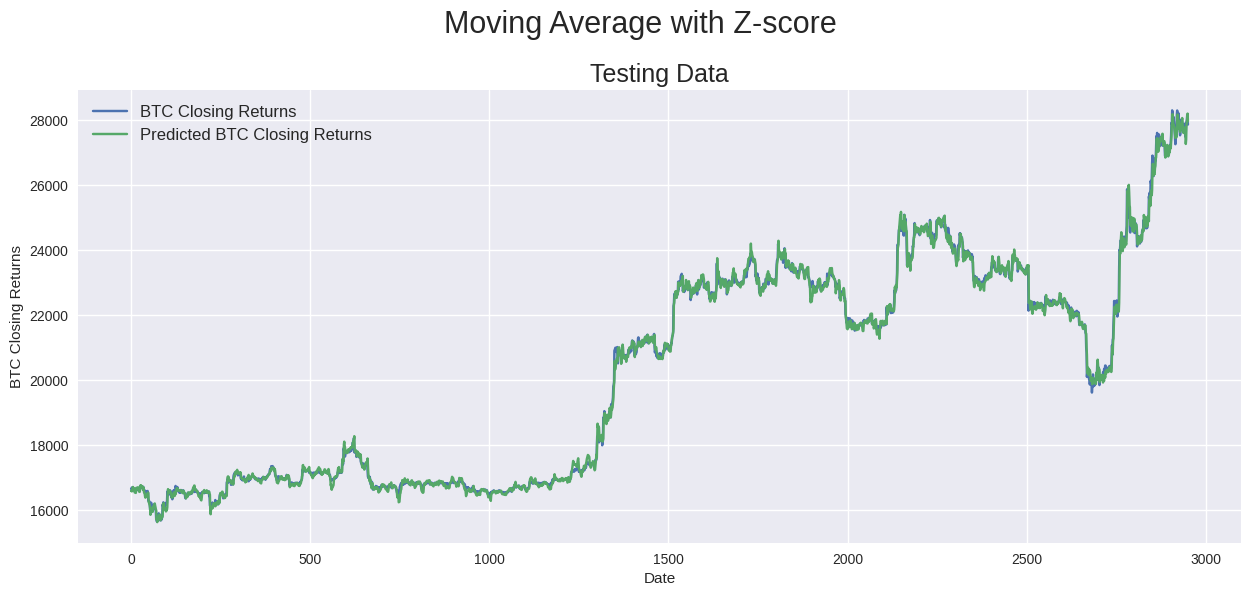

In [9]:
# draw all testing data prediction fig

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average with Z-score", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(restored_df['Close'][seq_len:].values, label='BTC Closing Returns')
ax11.plot(restored_df['pred_Close'][seq_len:].values, label='Predicted BTC Closing Returns')
ax11.set_title("Testing Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC Closing Returns')
ax11.legend(loc="best", fontsize=12)

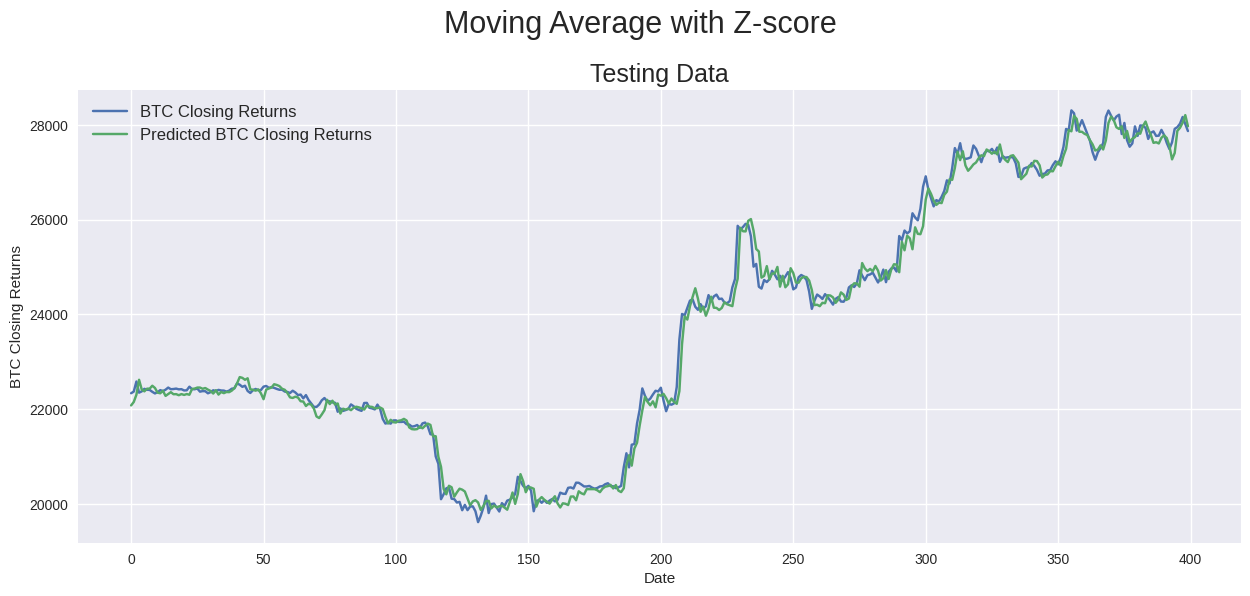

In [10]:
# draw with first 400 testing data prediction
seq_len = 128
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average with Z-score", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(restored_df['Close'][-400:].values, label='BTC Closing Returns')
ax11.plot(restored_df['pred_Close'][-400:].values, label='Predicted BTC Closing Returns')
ax11.set_title("Testing Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC Closing Returns')
ax11.legend(loc="best", fontsize=12)

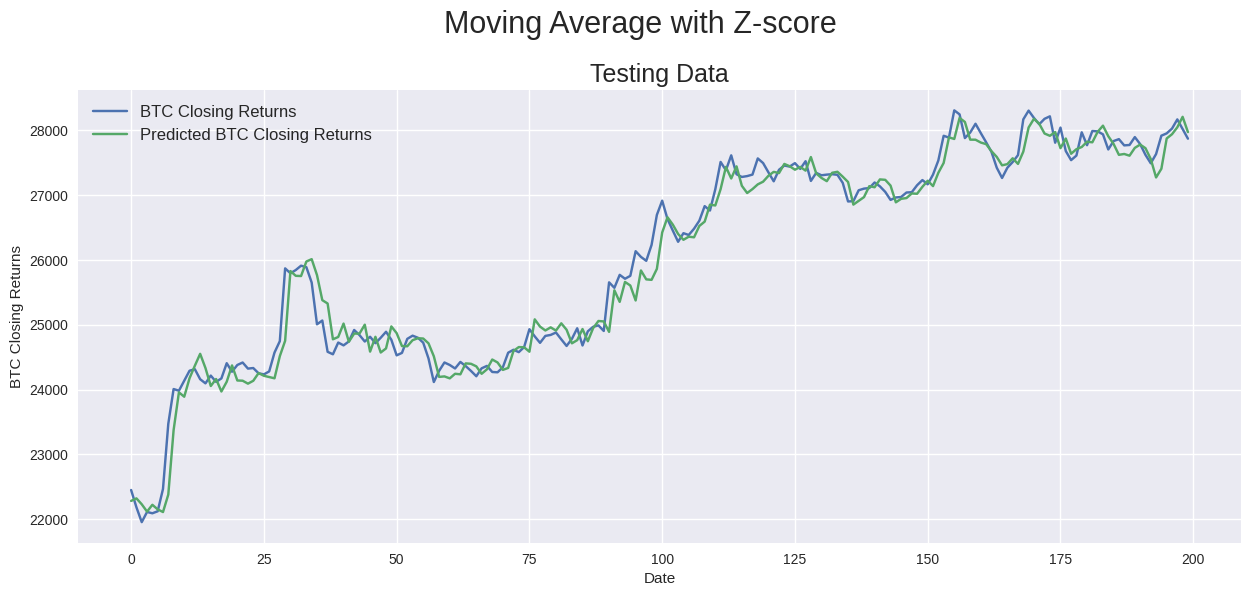

In [11]:
# draw with first 400 testing data prediction
seq_len = 128
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average with Z-score", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(restored_df['Close'][-200:].values, label='BTC Closing Returns')
ax11.plot(restored_df['pred_Close'][-200:].values, label='Predicted BTC Closing Returns')
ax11.set_title("Testing Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC Closing Returns')
ax11.legend(loc="best", fontsize=12)

In [14]:
restored_df[['Close','pred_Close']]

,Close,pred_Close
0,16626.8,-
1,16568.4,-
2,16578.1,-
3,16546.3,-
4,16521.1,-
...,...,...
3074,27952.2,27873.722283
3075,28026.1,27938.858895
3076,28167.7,28045.972119
3077,28019.1,28207.407079
